# Tutorial 2

In [1]:
from neo4j import GraphDatabase
import matplotlib.pyplot as plt
import numpy as np


### Connection to the database instance

In [2]:
driver = GraphDatabase.driver("bolt://localhost:7687", auth=("neo4j", "12345"))

### Question 1

Find all actors that directed a movie they also acted in and print the actor's name and the titles of the movies as a list.

In [3]:
query = """
MATCH (a:Person)-[:DIRECTED]->(b:Movie), (a:Person)-[:ACTED_IN]->(b:Movie)
RETURN a.name AS name, collect(b.title) AS titles
"""

with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["name"], record["titles"])

Tom Hanks ['That Thing You Do']
Clint Eastwood ['Unforgiven']
Danny DeVito ['Hoffa']


### Question 2

Find all reviewer pairs, one following the other, and return the names of the two reviewers. If they have both reviewed the same movie, return the title of the movie as well.

In [4]:
query = """
MATCH (a:Person)-[:REVIEWED]->(:Movie),
(b:Person)-[:REVIEWED]->(:Movie),
(a:Person)-[:FOLLOWS]->(b:Person)
OPTIONAL MATCH (a:Person)-[:REVIEWED]->(m:Movie)<-[:REVIEWED]-(b:Person)
RETURN DISTINCT a.name AS name1, b.name AS name2, m.title AS title
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["name1"],record["name2"],record["title"])

James Thompson Jessica Thompson The Da Vinci Code
James Thompson Jessica Thompson The Replacements
Angela Scope Jessica Thompson The Replacements


### Question 3

Restrict the previous query so that the first letter of the name of both reviewers is 'J'.

In [5]:
query = """
MATCH (a:Person)-[:REVIEWED]->(:Movie), (b:Person)-[:REVIEWED]->(:Movie), (a:Person)-[:FOLLOWS]->(b:Person)
WHERE a.name STARTS WITH 'J'
AND b.name STARTS WITH 'J'
OPTIONAL MATCH (a:Person)-[:REVIEWED]->(m:Movie)<-[:REVIEWED]-(b:Person)
RETURN DISTINCT a.name AS name1, b.name AS name2, m.title AS title
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["name1"],record["name2"],record["title"])

James Thompson Jessica Thompson The Da Vinci Code
James Thompson Jessica Thompson The Replacements


### Question 4

Find all actors that have acted in a movie together after 2010 and return their names and the movie title.

In [6]:
query = """
MATCH (a:Person)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(b:Person)
WHERE m.released > 2010
AND a.name < b.name
RETURN DISTINCT a.name AS name1, b.name AS name2, m.title AS title
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["name1"],record["name2"],record["title"])

Jim Broadbent Tom Hanks Cloud Atlas
Halle Berry Tom Hanks Cloud Atlas
Hugo Weaving Tom Hanks Cloud Atlas
Halle Berry Jim Broadbent Cloud Atlas
Hugo Weaving Jim Broadbent Cloud Atlas
Halle Berry Hugo Weaving Cloud Atlas


### Question 5

Find all actors that have acted in at least 3 movies together, and print the names of the actors and the movie titles as a list.

In [7]:
query = """
MATCH (a:Person)-[:ACTED_IN]->(m:Movie)<-[:ACTED_IN]-(b:Person)
WITH a.name AS name1, b.name AS name2, collect(m.title) AS col
WHERE size(col) >= 3
AND name1 < name2
RETURN DISTINCT name1, name2, col
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["name1"],record["name2"],record["col"])

Carrie-Anne Moss Hugo Weaving ['The Matrix', 'The Matrix Reloaded', 'The Matrix Revolutions']
Hugo Weaving Laurence Fishburne ['The Matrix', 'The Matrix Reloaded', 'The Matrix Revolutions']
Carrie-Anne Moss Laurence Fishburne ['The Matrix', 'The Matrix Reloaded', 'The Matrix Revolutions']
Keanu Reeves Laurence Fishburne ['The Matrix', 'The Matrix Reloaded', 'The Matrix Revolutions']
Hugo Weaving Keanu Reeves ['The Matrix', 'The Matrix Reloaded', 'The Matrix Revolutions']
Carrie-Anne Moss Keanu Reeves ['The Matrix', 'The Matrix Reloaded', 'The Matrix Revolutions']
Meg Ryan Tom Hanks ["You've Got Mail", 'Sleepless in Seattle', 'Joe Versus the Volcano']


### Question 6

Match all reviewers and the one they are following directly or via another a third reviewer. Print also the degree of their connection.

In [8]:
query = """
MATCH (a:Person)-[:REVIEWED]->(:Movie), (b:Person)-[:REVIEWED]->(:Movie)
MATCH p=(a:Person)-[:FOLLOWS*..2]->(b:Person)
RETURN a.name, b.name, length(p) AS degree
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["a.name"],record["b.name"],record["degree"])

James Thompson Jessica Thompson 1
James Thompson Jessica Thompson 1
Angela Scope Jessica Thompson 1
James Thompson Jessica Thompson 1
James Thompson Jessica Thompson 1
Angela Scope Jessica Thompson 1
James Thompson Jessica Thompson 1
James Thompson Jessica Thompson 1
Angela Scope Jessica Thompson 1
James Thompson Jessica Thompson 1
James Thompson Jessica Thompson 1
Angela Scope Jessica Thompson 1
James Thompson Jessica Thompson 1
James Thompson Jessica Thompson 1
Angela Scope Jessica Thompson 1
James Thompson Jessica Thompson 1
James Thompson Jessica Thompson 1
Angela Scope Jessica Thompson 1


### Question 7

Count the people that can be reached from Clint Eastwood in at most 4 hops ignoring edge direction

In [9]:
query = """
MATCH (a:Person {name: 'Clint Eastwood'})-[*..4]-(b:Person)
WHERE a <> b
RETURN count(DISTINCT b) AS cnt
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["cnt"])

36


### Question 8

Determine the average age of the Apollo 13 cast at the time of the release of the movie.

In [10]:
query = """
MATCH (a:Person)-[:ACTED_IN]->(b:Movie {title: 'Apollo 13'})
RETURN avg(b.released-a.born) AS avgAge
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["avgAge"])

40.2


### Question 9

Find the 10 movies with the oldest cast at the time of the movie’s release.

In [11]:
query = """
MATCH (a:Person)-[:ACTED_IN]->(b:Movie)
WITH b, avg(b.released-a.born) AS avgAge
RETURN b.title AS title, avgAge 
ORDER BY avgAge DESC
LIMIT 10
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["title"],record["avgAge"])

Unforgiven 62.0
Cloud Atlas 54.25
Something's Gotta Give 54.0
The Birdcage 50.333333333333336
Frost/Nixon 49.4
The Polar Express 48.0
What Dreams May Come 48.0
V for Vendetta 47.2
RescueDawn 46.75
Snow Falling on Cedars 46.5


### Question 10

Find the youngest actors in each movie cast at time of release and compute the average age of all such actors.

In [12]:
query = """
MATCH (a:Person)-[:ACTED_IN]->(b:Movie)
WITH b, min(b.released-a.born) AS minAge
RETURN avg(minAge) AS avgMinAge
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["avgMinAge"])

30.842105263157894


### Question 11

Print the degree distribution of all nodes representing movies.

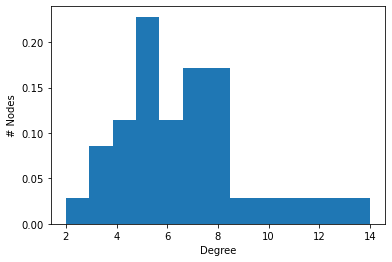

In [16]:
query = """
MATCH ()-[r]-(m:Movie)
WITH m, count(DISTINCT r) AS degree
RETURN degree
ORDER BY degree ASC"""

x = []
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        x.append(int(record["degree"]))
    
plt.hist(x, density=True, bins=(max(x)-min(x)+1)) 
plt.ylabel('# Nodes')
plt.xlabel('Degree');
plt.show()

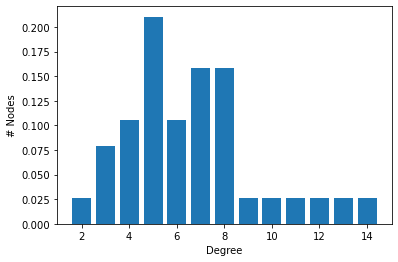

In [24]:
query = """
MATCH (a:Movie)
WITH count(a) AS movieCount
MATCH ()-[r]-(m:Movie)
WITH m, count(DISTINCT r) AS degree, movieCount
RETURN degree, (count(degree)/toFloat(movieCount)) AS cnt
ORDER BY degree ASC"""

x = []
y = []
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        x.append(int(record["degree"]))
        y.append(float(record["cnt"]))

plt.bar(x,y)
plt.ylabel('# Nodes')
plt.xlabel('Degree');
plt.show()


### Question 12

Print the number of occurences of relationships of each type. Print both the type and the number of accurences.

In [14]:
query = """
MATCH ()-[r]->()
WITH type(r) AS edgeType, count(type(r)) AS typeCount
RETURN edgeType, typeCount
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["edgeType"], record["typeCount"])

ACTED_IN 172
PRODUCED 15
DIRECTED 44
WROTE 10
REVIEWED 9
FOLLOWS 3


### Question 13

Find the number of movies that have an average rating higher than 50 and have a tagline. Print the title of the movie and the tagline.

In [15]:
query = """
MATCH ()-[r:REVIEWED]->(m)
WITH m, avg(r.rating) AS rating
WHERE m.tagline IS NOT NULL
AND rating > 50
RETURN m.title AS title, m.tagline AS tagline
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["title"], record["tagline"])

Jerry Maguire The rest of his life begins now.
The Replacements Pain heals, Chicks dig scars... Glory lasts forever
Unforgiven It's a hell of a thing, killing a man
Cloud Atlas Everything is connected
The Da Vinci Code Break The Codes


### Question 14

Find for each actor the highest rating a movie he has acted in has received (cosider the average of all ratings for each movie). Order the results in alphabetical order of the actors surname (assume each actor has one first name and one last name).

In [16]:
query = """
MATCH ()-[r:REVIEWED]->(b)
WITH b, avg(r.rating) AS rating
MATCH (a)-[:ACTED_IN]->(b)
WITH a.name AS aName, max(rating) AS maxR
RETURN DISTINCT aName, maxR
ORDER BY tail(split(aName,' '))
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["aName"],record["maxR"])

Halle Berry 95.0
Paul Bettany 66.5
Jim Broadbent 95.0
Tom Cruise 92.0
Clint Eastwood 85.0
Cuba Gooding Jr. 92.0
Gene Hackman 85.0
Tom Hanks 95.0
Richard Harris 85.0
Bonnie Hunt 92.0
Orlando Jones 75.66666666666667
Regina King 92.0
Nathan Lane 45.0
Brooke Langton 75.66666666666667
Jonathan Lipnicki 92.0
Ian McKellen 66.5
Jay Mohr 92.0
Jerry O'Connell 92.0
Kelly Preston 92.0
Keanu Reeves 75.66666666666667
Audrey Tautou 66.5
Hugo Weaving 95.0
Robin Williams 45.0
Renee Zellweger 92.0


### Question 15

Find the Bacon number of each actor. 

- Kevin Bacon himself has a Bacon number of 0.
- Those actors who have worked directly with Kevin Bacon have a Bacon number of 1.
- If the lowest Bacon number of any actor with whom X has appeared in any movie is N, X's Bacon number is N+1.

In [17]:
query = """
MATCH p=shortestPath((a:Person)-[:ACTED_IN*]-(b:Person))
WHERE b.name = 'Kevin Bacon'
AND a.name <> 'Kevin Bacon'
RETURN a.name AS name, length(p)/2 AS baconNumber
"""
        
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(record["name"],record["baconNumber"])

Keanu Reeves 2
Carrie-Anne Moss 3
Laurence Fishburne 3
Hugo Weaving 2
Emil Eifrem 3
Charlize Theron 2
Al Pacino 3
Tom Cruise 1
Jack Nicholson 1
Demi Moore 1
Kiefer Sutherland 1
Noah Wyle 1
Cuba Gooding Jr. 1
Kevin Pollak 1
J.T. Walsh 1
James Marshall 1
Christopher Guest 1
Aaron Sorkin 1
Kelly McGillis 2
Val Kilmer 2
Anthony Edwards 2
Tom Skerritt 2
Meg Ryan 2
Renee Zellweger 2
Kelly Preston 2
Jerry O'Connell 2
Jay Mohr 2
Bonnie Hunt 2
Regina King 2
Jonathan Lipnicki 2
River Phoenix 2
Corey Feldman 2
Wil Wheaton 2
John Cusack 2
Marshall Bell 2
Helen Hunt 2
Greg Kinnear 2
Annabella Sciorra 2
Max von Sydow 2
Werner Herzog 2
Robin Williams 2
Ethan Hawke 3
Rick Yune 3
James Cromwell 2
Parker Posey 2
Dave Chappelle 2
Steve Zahn 2
Tom Hanks 1
Rita Wilson 2
Bill Pullman 2
Victor Garber 2
Rosie O'Donnell 2
Nathan Lane 2
Billy Crystal 3
Carrie Fisher 3
Bruno Kirby 3
Liv Tyler 2
Brooke Langton 3
Gene Hackman 3
Orlando Jones 3
Christian Bale 3
Zach Grenier 2
Richard Harris 4
Clint Eastwood 4
Takes